<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Description</a></span></li><li><span><a href="#Load-the-libraries" data-toc-modified-id="Load-the-libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load the libraries</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Processing</a></span></li><li><span><a href="#Take-Most-Visited-Page-as-Timeseries" data-toc-modified-id="Take-Most-Visited-Page-as-Timeseries-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Take Most Visited Page as Timeseries</a></span></li><li><span><a href="#Modelling:-VAR" data-toc-modified-id="Modelling:-VAR-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Modelling: VAR</a></span></li><li><span><a href="#Multivariate-time-series-creation" data-toc-modified-id="Multivariate-time-series-creation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Multivariate time series creation</a></span></li><li><span><a href="#Testing-Causation-using-Granger’s-Causality-Test" data-toc-modified-id="Testing-Causation-using-Granger’s-Causality-Test-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Testing Causation using Granger’s Causality Test</a></span></li><li><span><a href="#Cointegration-Test" data-toc-modified-id="Cointegration-Test-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Cointegration Test</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#Check-for-Stationarity-and-Make-the-Time-Series-Stationary" data-toc-modified-id="Check-for-Stationarity-and-Make-the-Time-Series-Stationary-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Check for Stationarity and Make the Time Series Stationary</a></span></li><li><span><a href="#How-to-Select-the-Order-(P)-of-VAR-model" data-toc-modified-id="How-to-Select-the-Order-(P)-of-VAR-model-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>How to Select the Order (P) of VAR model</a></span></li><li><span><a href="#Train-the-VAR-Model-of-Selected-Order(p)" data-toc-modified-id="Train-the-VAR-Model-of-Selected-Order(p)-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Train the VAR Model of Selected Order(p)</a></span></li><li><span><a href="#Check-for-Serial-Correlation-of-Residuals-(Errors)-using-Durbin-Watson-Statistic" data-toc-modified-id="Check-for-Serial-Correlation-of-Residuals-(Errors)-using-Durbin-Watson-Statistic-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic</a></span></li><li><span><a href="#How-to-Forecast-VAR-model-using-statsmodels" data-toc-modified-id="How-to-Forecast-VAR-model-using-statsmodels-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>How to Forecast VAR model using statsmodels</a></span></li><li><span><a href="#Invert-the-transformation-to-get-the-real-forecast" data-toc-modified-id="Invert-the-transformation-to-get-the-real-forecast-16"><span class="toc-item-num">16&nbsp;&nbsp;</span>Invert the transformation to get the real forecast</a></span></li><li><span><a href="#Plot-of-Forecast-vs-Actuals" data-toc-modified-id="Plot-of-Forecast-vs-Actuals-17"><span class="toc-item-num">17&nbsp;&nbsp;</span>Plot of Forecast vs Actuals</a></span></li><li><span><a href="#Evaluate-the-Forecasts" data-toc-modified-id="Evaluate-the-Forecasts-18"><span class="toc-item-num">18&nbsp;&nbsp;</span>Evaluate the Forecasts</a></span></li></ul></div>

# Data Description

Reference: https://www.kaggle.com/c/web-traffic-time-series-forecasting/data

```
Original data: train_1.csv
-----------------------------
rows = 145,063
columns = 551
first column = Page
date columns = 2015-07-01, 2015-07-02, ..., 2016-12-31 (550 columns)
file size: 284.6 MB



Modelling data
----------------------------------------------
selected year: 2016 (leap year 366 days)
             
```

# Load the libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (12,8)})
plt.style.use('fivethirtyeight') # better than sns styles.
matplotlib.rcParams['figure.figsize'] = 12,8

import os
import time

# random state
SEED=100
np.random.seed(SEED)

# Jupyter notebook settings for pandas
#pd.set_option('display.float_format', '{:,.2g}'.format) # numbers sep by comma
from pandas.api.types import CategoricalDtype
np.set_printoptions(precision=3)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 200)

import IPython
from IPython.display import display, HTML, Image, Markdown

import gc

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import statsmodels.robust as smrb # smrb.mad() etc
import patsy # y,X1 = patsy.dmatrices(formula, df, return_type='dataframe')

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Load the data

In [3]:
df = pd.read_csv('../data/train_1.csv.zip',compression='zip',encoding='latin-1')
print(df.shape)
display(df.head())

(145063, 551)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,...,2016-11-12,2016-11-13,2016-11-14,2016-11-15,2016-11-16,2016-11-17,2016-11-18,2016-11-19,2016-11-20,2016-11-21,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,10.0,5.0,9.0,9.0,9.0,9.0,13.0,4.0,15.0,25.0,...,13.0,8.0,15.0,14.0,12.0,6.0,11.0,10.0,42.0,21.0,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,12.0,27.0,27.0,36.0,23.0,58.0,80.0,60.0,69.0,42.0,...,12.0,11.0,14.0,28.0,23.0,20.0,9.0,12.0,11.0,14.0,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,4.0,5.0,0.0,0.0,7.0,3.0,5.0,1.0,6.0,2.0,...,6.0,4.0,2.0,4.0,6.0,5.0,4.0,4.0,3.0,3.0,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,8.0,27.0,19.0,16.0,2.0,84.0,22.0,14.0,47.0,25.0,...,38.0,13.0,14.0,17.0,26.0,14.0,10.0,9.0,23.0,15.0,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.0,11.0,8.0,6.0,10.0,14.0,6.0,9.0,6.0,16.0,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


# Data Processing

In [4]:
import functools

@functools.lru_cache(maxsize=None)
def clean_df():
    # load the data
    df = pd.read_csv('../data/train_1.csv.zip',compression='zip',encoding='latin-1')

    # small data
    df = df.sample(frac=0.01,random_state=SEED)

    # description said zeros and nans are same
    df = df.fillna(0)

    # reduce memory
    df.iloc[:,1:] = df.iloc[:,1:].astype(np.int32)

    # data of year 2016 only
    t1 = pd.Timestamp('2015-07-01')
    t2 = pd.Timestamp('2016-01-01')
    diff = (t2-t1).days
    df = df.iloc[:, np.r_[0,diff+1:diff+1+366]]

    # make long data
    df = df.melt(id_vars=['Page'],var_name='date',value_name='visits')

    # time features
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year # yyyy
    df['month'] = df['date'].dt.month # 1 to 12
    df['day'] = df['date'].dt.day # 1 to 31
    df['quarter'] = df['date'].dt.quarter # 1 to 4
    df['dayofweek'] = df['date'].dt.dayofweek # 0 to 6
    df['dayofyear'] = df['date'].dt.dayofyear # 1 to 366 (leap year)
    df['day_name'] = df['date'].dt.day_name() # Monday
    df['month_name'] = df['date'].dt.month_name() # January
    df['weekend'] = ((df['date'].dt.dayofweek) // 5 == 1)
    df['weekday'] = ((df['date'].dt.dayofweek) // 5 != 1)

    # agg features
    df['mean'] = df.groupby('Page')['visits'].transform('mean')
    df['median'] = df.groupby('Page')['visits'].transform('median')

    # new features
    df['agent'] = df['Page'].str.split('_').str[-1]
    df['access'] = df['Page'].str.split('_').str[-2]
    df['project'] = df['Page'].str.split('_').str[-3]
    df['name'] = df['Page'].str.split('_').str[:-3].str.join('_')

    # language
    lang_map ={'en':'English','ja':'Japanese','de':'German',
            'www':'Media','fr':'French','zh':'Chinese',
            'ru':'Russian','es':'Spanish','commons': 'Media'
           }
    df['lang'] = df['project'].str.split('.').str[0]
    df['language'] = df['lang'].map(lang_map)

    # all the year is 2016,drop it.
    df.drop('year',axis=1,inplace=True)

    # memory reduction
    cols_int = ['visits']
    cols_cat = ['month','day','quarter','day_name','month_name',
                'project','access','agent','language']
    cols_float = ['mean','median']
    for c in cols_int: df[c] = df[c].astype(np.int32)
    for c in cols_float: df[c] = df[c].astype(np.float32)
    for c in cols_cat: df[c] = df[c].astype(pd.api.types.CategoricalDtype())

    # make day_name and month_name ordered categorical
    cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['day_name'] = pd.Categorical(df['day_name'], ordered=True, categories=cats)
    cats = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
           'August', 'September', 'October', 'November', 'December']
    df['month_name'] = pd.Categorical(df['month_name'], ordered=True, categories=cats)

    return df

df = clean_df()
df.head()

,Page,date,visits,month,day,quarter,dayofweek,dayofyear,day_name,month_name,weekend,weekday,mean,median,agent,access,project,name,lang,language
0,Sean_Connery_en.wikipedia.org_desktop_all-agents,2016-01-01,4872,1,1,1,4,1,Friday,January,False,True,3405.661133,2624.0,all-agents,desktop,en.wikipedia.org,Sean_Connery,en,English
1,Tableau_des_mÃ©dailles_des_Jeux_olympiques_d'Ã©tÃ©_de_2008_fr.wikipedia.org_desktop_all-agents,2016-01-01,6,1,1,1,4,1,Friday,January,False,True,170.841537,18.0,all-agents,desktop,fr.wikipedia.org,Tableau_des_mÃ©dailles_des_Jeux_olympiques_d'Ã©tÃ©_de_2008,fr,French
2,The_Undertaker_fr.wikipedia.org_mobile-web_all-agents,2016-01-01,469,1,1,1,4,1,Friday,January,False,True,400.336060,345.5,all-agents,mobile-web,fr.wikipedia.org,The_Undertaker,fr,French
3,Category:Outdoor_sex_commons.wikimedia.org_all-access_all-agents,2016-01-01,142,1,1,1,4,1,Friday,January,False,True,205.174866,193.0,all-agents,all-access,commons.wikimedia.org,Category:Outdoor_sex,commons,Media
4,ÐÐ°Ð¼ÑÐ·ÑÐº_ru.wikipedia.org_all-access_all-agents,2016-01-01,6692,1,1,1,4,1,Friday,January,False,True,912.516418,559.0,all-agents,all-access,ru.wikipedia.org,ÐÐ°Ð¼ÑÐ·ÑÐº,ru,Russian


# Take Most Visited Page as Timeseries

In [5]:
# top pages per language
df.groupby('language')['visits'].apply(lambda x: df.loc[x.nlargest(1).index])

,,Page,date,visits,month,day,quarter,dayofweek,dayofyear,day_name,month_name,weekend,weekday,mean,median,agent,access,project,name,lang,language
language,,,,,,,,,,,,,,,,,,,,,
Chinese,359618,å±å_zh.wikipedia.org_desktop_all-agents,2016-09-04,79490,9,4,3,6,248,Sunday,September,True,False,580.912598,235.5,all-agents,desktop,zh.wikipedia.org,å±å,zh,Chinese
English,150393,Special:RecentChangesLinked_en.wikipedia.org_desktop_all-agents,2016-04-13,853784,4,13,2,2,104,Wednesday,April,False,True,69805.703125,34649.5,all-agents,desktop,en.wikipedia.org,Special:RecentChangesLinked,en,English
French,28471,Guy_Georges_fr.wikipedia.org_all-access_all-agents,2016-01-20,120647,1,20,1,2,20,Wednesday,January,False,True,1541.696777,474.0,all-agents,all-access,fr.wikipedia.org,Guy_Georges,fr,French
German,444962,GerÃ¤testecker_de.wikipedia.org_desktop_all-agents,2016-11-02,558381,11,2,4,2,307,Wednesday,November,False,True,1870.743164,398.0,all-agents,desktop,de.wikipedia.org,GerÃ¤testecker,de,German
Japanese,187547,ãã©ã­ã¤ã_ja.wikipedia.org_desktop_all-agents,2016-05-09,1000441,5,9,2,0,130,Monday,May,False,True,2780.065674,44.0,all-agents,desktop,ja.wikipedia.org,ãã©ã­ã¤ã,ja,Japanese
Media,126253,MediaWiki:Sitenotice-translation_commons.wikimedia.org_desktop_all-agents,2016-03-28,84197,3,28,1,0,88,Monday,March,False,True,1044.579224,1.0,all-agents,desktop,commons.wikimedia.org,MediaWiki:Sitenotice-translation,commons,Media
Russian,226282,"ÐÐ»Ð¸,_ÐÐ¾Ñ Ð°Ð¼Ð¼ÐµÐ´_ru.wikipedia.org_all-access_all-agents",2016-06-04,562514,6,4,2,5,156,Saturday,June,True,False,5483.262207,2232.0,all-agents,all-access,ru.wikipedia.org,"ÐÐ»Ð¸,_ÐÐ¾Ñ Ð°Ð¼Ð¼ÐµÐ´",ru,Russian
Spanish,455139,Colegio_Electoral_de_los_Estados_Unidos_es.wikipedia.org_mobile-web_all-agents,2016-11-09,224685,11,9,4,2,314,Wednesday,November,False,True,1188.204956,132.5,all-agents,mobile-web,es.wikipedia.org,Colegio_Electoral_de_los_Estados_Unidos,es,Spanish


# Modelling: VAR

References:  
- [VAR statsmodels official](https://www.statsmodels.org/stable/vector_ar.html)

**VAR(p) processes**  
We are interested in modeling a 𝑇×𝐾 multivariate time series 𝑌, where 𝑇 denotes the number of observations and 𝐾 the number of variables. One way of estimating relationships between the time series and their lagged values is the vector autoregression process:

$$
\begin{aligned} Y_{t}=A_{1} Y_{t-1}+\ldots &+A_{p} Y_{t-p}+u_{t} \\ u_{t} & \sim \operatorname{Normal}\left(0, \Sigma_{u}\right) \end{aligned}
$$

where 𝐴𝑖 is a 𝐾×𝐾 coefficient matrix.


Reference: https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series


Vector autoregression (VAR) is a stochastic process model used to capture the linear interdependencies among multiple time series. VAR models generalize the univariate autoregressive model (AR model) by allowing for more than one evolving variable. All variables in a VAR enter the model in the same way: each variable has an equation explaining its evolution based on its own lagged values, the lagged values of the other model variables, and an error term. VAR modeling does not require as much knowledge about the forces influencing a variable as do structural models with simultaneous equations: The only prior knowledge required is a list of variables which can be hypothesized to affect each other intertemporally.

![](../images/var_model_description.png)


Reference: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/  

Vector Autoregression (VAR) is a multivariate forecasting algorithm that is used when two or more time series influence each other.

That means, the basic requirements in order to use VAR are:

- You need atleast two time series (variables)
- The time series should influence each other. (e.g. opening and closing stock)

Alright. So why is it called ‘Autoregressive’?

It is considered as an Autoregressive model because, each variable (Time Series) is modeled as a function of the past values, that is the predictors are nothing but the lags (time delayed value) of the series.

Ok, so how is VAR different from other Autoregressive models like AR, ARMA or ARIMA?

The primary difference is those models are uni-directional, where, the predictors influence the Y and not vice-versa. Whereas, Vector Auto Regression (VAR) is bi-directional. That is, the variables influence each other.

# Multivariate time series creation

In [6]:
# top pages per language
df.groupby('language')['visits'].apply(lambda x: df.loc[x.nlargest(1).index])

,,Page,date,visits,month,day,quarter,dayofweek,dayofyear,day_name,month_name,weekend,weekday,mean,median,agent,access,project,name,lang,language
language,,,,,,,,,,,,,,,,,,,,,
Chinese,359618,å±å_zh.wikipedia.org_desktop_all-agents,2016-09-04,79490,9,4,3,6,248,Sunday,September,True,False,580.912598,235.5,all-agents,desktop,zh.wikipedia.org,å±å,zh,Chinese
English,150393,Special:RecentChangesLinked_en.wikipedia.org_desktop_all-agents,2016-04-13,853784,4,13,2,2,104,Wednesday,April,False,True,69805.703125,34649.5,all-agents,desktop,en.wikipedia.org,Special:RecentChangesLinked,en,English
French,28471,Guy_Georges_fr.wikipedia.org_all-access_all-agents,2016-01-20,120647,1,20,1,2,20,Wednesday,January,False,True,1541.696777,474.0,all-agents,all-access,fr.wikipedia.org,Guy_Georges,fr,French
German,444962,GerÃ¤testecker_de.wikipedia.org_desktop_all-agents,2016-11-02,558381,11,2,4,2,307,Wednesday,November,False,True,1870.743164,398.0,all-agents,desktop,de.wikipedia.org,GerÃ¤testecker,de,German
Japanese,187547,ãã©ã­ã¤ã_ja.wikipedia.org_desktop_all-agents,2016-05-09,1000441,5,9,2,0,130,Monday,May,False,True,2780.065674,44.0,all-agents,desktop,ja.wikipedia.org,ãã©ã­ã¤ã,ja,Japanese
Media,126253,MediaWiki:Sitenotice-translation_commons.wikimedia.org_desktop_all-agents,2016-03-28,84197,3,28,1,0,88,Monday,March,False,True,1044.579224,1.0,all-agents,desktop,commons.wikimedia.org,MediaWiki:Sitenotice-translation,commons,Media
Russian,226282,"ÐÐ»Ð¸,_ÐÐ¾Ñ Ð°Ð¼Ð¼ÐµÐ´_ru.wikipedia.org_all-access_all-agents",2016-06-04,562514,6,4,2,5,156,Saturday,June,True,False,5483.262207,2232.0,all-agents,all-access,ru.wikipedia.org,"ÐÐ»Ð¸,_ÐÐ¾Ñ Ð°Ð¼Ð¼ÐµÐ´",ru,Russian
Spanish,455139,Colegio_Electoral_de_los_Estados_Unidos_es.wikipedia.org_mobile-web_all-agents,2016-11-09,224685,11,9,4,2,314,Wednesday,November,False,True,1188.204956,132.5,all-agents,mobile-web,es.wikipedia.org,Colegio_Electoral_de_los_Estados_Unidos,es,Spanish


In [7]:
# we need two DEPENDENT timeseries for VAR
# I don't have dependent timeseries, but I will assume
# top english and top french wikipedia articles are dependent.

In [8]:
df.groupby('language')['visits'].apply(lambda x: df.loc[x.nlargest(1).index]).nlargest(2, 'visits')

,,Page,date,visits,month,day,quarter,dayofweek,dayofyear,day_name,month_name,weekend,weekday,mean,median,agent,access,project,name,lang,language
language,,,,,,,,,,,,,,,,,,,,,
Japanese,187547,ãã©ã­ã¤ã_ja.wikipedia.org_desktop_all-agents,2016-05-09,1000441,5,9,2,0,130,Monday,May,False,True,2780.065674,44.0,all-agents,desktop,ja.wikipedia.org,ãã©ã­ã¤ã,ja,Japanese
English,150393,Special:RecentChangesLinked_en.wikipedia.org_desktop_all-agents,2016-04-13,853784,4,13,2,2,104,Wednesday,April,False,True,69805.703125,34649.5,all-agents,desktop,en.wikipedia.org,Special:RecentChangesLinked,en,English


In [9]:
first, second = df.groupby('language')['visits'].apply(lambda x: df.loc[x.nlargest(1).index]).nlargest(2, 'visits')['Page'].to_numpy()

first, second

('ã\x83\x9dã\x83©ã\x83\xadã\x82¤ã\x83\x89_ja.wikipedia.org_desktop_all-agents',
 'Special:RecentChangesLinked_en.wikipedia.org_desktop_all-agents')

In [10]:
df.query(""" Page == @first """).head(2).append(
    df.query(""" Page == @second """).head(2))

,Page,date,visits,month,day,quarter,dayofweek,dayofyear,day_name,month_name,weekend,weekday,mean,median,agent,access,project,name,lang,language
368,ãã©ã­ã¤ã_ja.wikipedia.org_desktop_all-agents,2016-01-01,34,1,1,1,4,1,Friday,January,False,True,2780.065674,44.0,all-agents,desktop,ja.wikipedia.org,ãã©ã­ã¤ã,ja,Japanese
1819,ãã©ã­ã¤ã_ja.wikipedia.org_desktop_all-agents,2016-01-02,31,1,2,1,5,2,Saturday,January,True,False,2780.065674,44.0,all-agents,desktop,ja.wikipedia.org,ãã©ã­ã¤ã,ja,Japanese
940,Special:RecentChangesLinked_en.wikipedia.org_desktop_all-agents,2016-01-01,28809,1,1,1,4,1,Friday,January,False,True,69805.703125,34649.5,all-agents,desktop,en.wikipedia.org,Special:RecentChangesLinked,en,English
2391,Special:RecentChangesLinked_en.wikipedia.org_desktop_all-agents,2016-01-02,23581,1,2,1,5,2,Saturday,January,True,False,69805.703125,34649.5,all-agents,desktop,en.wikipedia.org,Special:RecentChangesLinked,en,English


In [11]:
ts_df = pd.DataFrame({'English': df.query(""" Page == @first """)['visits'].to_numpy(),
                     'French': df.query(""" Page == @second """)['visits'].to_numpy()
                     }).astype(np.float32)
print(ts_df.isnull().sum().sum())
ts_df.head()

0


,English,French
0,34.0,28809.0
1,31.0,23581.0
2,47.0,42066.0
3,49.0,16696.0
4,48.0,24761.0


# Testing Causation using Granger’s Causality Test

Reference: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/ 


The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

So what does Granger’s Causality really test?

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

The below code implements the Granger’s Causality test for all possible combinations of the time series in a given dataframe and stores the p-values of each combination in the output matrix.

In [12]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(ts_df, variables = ts_df.columns) 

,English_x,French_x
English_y,1.0000,0.001
French_y,0.8068,1.000


So how to read the above output?

The row are the Response (Y) and the columns are the predictor series (X).

For example, if you take the value 0.0003 in (row 1, column 2), it refers to the p-value of pgnp_x causing rgnp_y. Whereas, the 0.000 in (row 2, column 1) refers to the p-value of rgnp_y causing pgnp_x.

So, how to interpret the p-values?

If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

For example, P-Value of 0.0003 at (row 1, column 2) represents the p-value of the Grangers Causality test for pgnp_x causing rgnp_y, which is less that the significance level of 0.05.

So, you can reject the null hypothesis and conclude pgnp_x causes rgnp_y.

Looking at the P-Values in the above table, you can pretty much observe that all the variables (time series) in the system are interchangeably causing each other.

This makes this system of multi time series a good candidate for using VAR models to forecast.

Next, let’s do the Cointegration test.

# Cointegration Test
Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.

But, what does Cointegration mean?

To understand that, you first need to know what is ‘order of integration’ (d).

Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary.

Now, when you have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated.

Ok?

When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.

This is the basic premise on which Vector Autoregression(VAR) models is based on. So, it’s fairly common to implement the cointegration test before starting to build VAR models.

Alright, So how to do this test?

Soren Johanssen in [his paper (1991)](https://www.jstor.org/stable/2938278?seq=1#page_scan_tab_contents) devised a procedure to implement the cointegration test.

It is fairly straightforward to implement in python’s statsmodels, as you can see below.

In [13]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(ts_df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
English ::  62.87     > 12.3212   =>   True
French ::  7.03      > 4.1296    =>   True


# Train Test Split

In [14]:
nobs = int(len(ts_df)*0.7)

df_train = ts_df.iloc[:nobs, :]
df_test = ts_df.iloc[nobs:, :]

df_train.head()

,English,French
0,34.0,28809.0
1,31.0,23581.0
2,47.0,42066.0
3,49.0,16696.0
4,48.0,24761.0


# Check for Stationarity and Make the Time Series Stationary

Ref: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/  
        
        
Since the VAR model requires the time series you want to forecast to be stationary, it is customary to check all the time series in the system for stationarity.

Just to refresh, a stationary time series is one whose characteristics like mean and variance does not change over time.

So, how to test for stationarity?

There is a suite of tests called unit-root tests. The popular ones are:

Augmented Dickey-Fuller Test (ADF Test)
KPSS test
Philip-Perron test
Let’s use the ADF test for our purpose.

By the way, if a series is found to be non-stationary, you make it stationary by differencing the series once and repeat the test again until it becomes stationary.

Since, differencing reduces the length of the series by 1 and since all the time series has to be of the same length, you need to difference all the series in the system if you choose to difference at all.

Got it?

Let’s implement the ADF Test.

First, we implement a nice function (adfuller_test()) that writes out the results of the ADF test for any given time series and implement this function on each series one-by-one.

In [15]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [16]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "English" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.9685
 No. Lags Chosen       = 0
 Critical value 1%     = -3.456
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "French" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1326
 No. Lags Chosen       = 7
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0242. Rejecting Null Hypothesis.
 => Series is Stationary.




In [17]:
# The ADF test confirms that both are stationary.
# Otherwise, we will differenciate and test again
# 
#
# 1st difference
# df_differenced = df_train.diff().dropna()

# # ADF Test on each column of 1st Differences Dataframe
# for name, column in df_differenced.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

# How to Select the Order (P) of VAR model
To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

Though the usual practice is to look at the AIC, you can also check other best fit comparison estimates of BIC, FPE and HQIC.

In [18]:
df_differenced = df_train # it was already stationary
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  44.584877730645005
BIC :  44.66820157876638
FPE :  2.3065736039728624e+19
HQIC:  44.61839408600957 

Lag Order = 2
AIC :  44.62171129195014
BIC :  44.760976420572916
FPE :  2.3931361395518194e+19
HQIC:  44.6777359538176 

Lag Order = 3
AIC :  44.64877063998493
BIC :  44.84429416900543
FPE :  2.4588213927712887e+19
HQIC:  44.727436314079114 

Lag Order = 4
AIC :  44.67704361420716
BIC :  44.92914569188654
FPE :  2.529413941999393e+19
HQIC:  44.778484267215255 

Lag Order = 5
AIC :  44.706941029159935
BIC :  45.015944872430445
FPE :  2.6063131026775466e+19
HQIC:  44.83129190507622 

Lag Order = 6
AIC :  44.726324209067634
BIC :  45.09255614452531
FPE :  2.6575249620999574e+19
HQIC:  44.87372184580328 

Lag Order = 7
AIC :  44.76346265027916
BIC :  45.18725215587731
FPE :  2.758364698389836e+19
HQIC:  44.934044896543426 

Lag Order = 8
AIC :  44.764642607617525
BIC :  45.24632235507563
FPE :  2.7620040554070237e+19
HQIC:  44.95854864007558 

Lag Order = 9
AIC :  44.59

In [19]:
# aic increase upto lag 7 and is mininum at lag =8
# we can choose lag = 8

In [20]:
# another method

x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,44.69,44.72,2.568e+19,44.70
1,44.52*,44.61*,2.172e+19*,44.56*
2,44.56,44.70,2.239e+19,44.61
3,44.58,44.78,2.286e+19,44.66
4,44.59,44.85,2.328e+19,44.70
5,44.61,44.93,2.375e+19,44.74
6,44.62,45.00,2.401e+19,44.77
7,44.65,45.08,2.473e+19,44.83
8,44.64,45.13,2.437e+19,44.84
9,44.63,45.17,2.403e+19,44.84


# Train the VAR Model of Selected Order(p)

In [21]:
results_var4 = model.fit(4)
results_var4.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Oct, 2020
Time:                     14:33:56
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    44.9291
Nobs:                     252.000    HQIC:                   44.7785
Log likelihood:          -6326.45    FPE:                2.52941e+19
AIC:                      44.6770    Det(Omega_mle):     2.35798e+19
--------------------------------------------------------------------
Results for equation English
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const           5687.009057      5774.328075            0.985           0.325
L1.English        -0.004865         0.064160           -0.076           0.940
L1.French         -0.012186         0.053837           -0.226         

# Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).

What does this mean to us?

If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.

Alright, coming back to topic.

A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic.

$$
D W=\frac{\Sigma_{t=2}^{T}\left(\left(e_{t}-e_{t-1}\right)^{2}\right)}{\Sigma_{t=1}^{T} e_{t}^{2}}
$$

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [22]:
def adjust(val, length= 6): 
    return str(val).ljust(length)

In [23]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(results_var4.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

Page   : 2.0
date   : 2.02


# How to Forecast VAR model using statsmodels

In order to forecast, the VAR model expects up to the lag order number of observations from the past data.

This is because, the terms in the VAR model are essentially the lags of the various time series in the dataset, so you need to provide it as many of the previous values as indicated by the lag order used by the model.

In [24]:
# Get the lag order
lag_order = results_var4.k_ar
print(lag_order)  # 4

# Input data for forecasting
forecast_input = df_differenced.to_numpy()[-lag_order:]
forecast_input

4


array([[   55.,  8992.],
       [   31., 15249.],
       [   39., 14209.],
       [   51., 14016.]], dtype=float32)

In [25]:
# Forecast

# note: if we have differenced twice our column names should be
# first_2d and second_2d
#
fc = results_var4.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=ts_df.index[-nobs:], columns=ts_df.columns)

print(df_train.shape, df_test.shape, df_forecast.shape)

df_forecast.head()

(256, 2) (110, 2) (256, 2)


,English,French
110,5298.300106,33644.332419
111,5008.030915,42009.423380
112,4644.144924,44039.737785
113,4495.055713,45760.523941
114,4346.050987,49008.058887


# Invert the transformation to get the real forecast

In [26]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale.
    
    If we have done 2nd diff:
    df_results = invert_transformation(df_train, df_forecast, second_diff=True)   
    
    """
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [27]:
# If we have differenced twice
# df_results = invert_transformation(df_train, df_forecast, second_diff=True)

In [28]:
df_results = df_forecast.rename(columns = lambda x: x+'_forecast') 
# we have not differenced at all

df_results.head(2)

,English_forecast,French_forecast
110,5298.300106,33644.332419
111,5008.030915,42009.423380


# Plot of Forecast vs Actuals

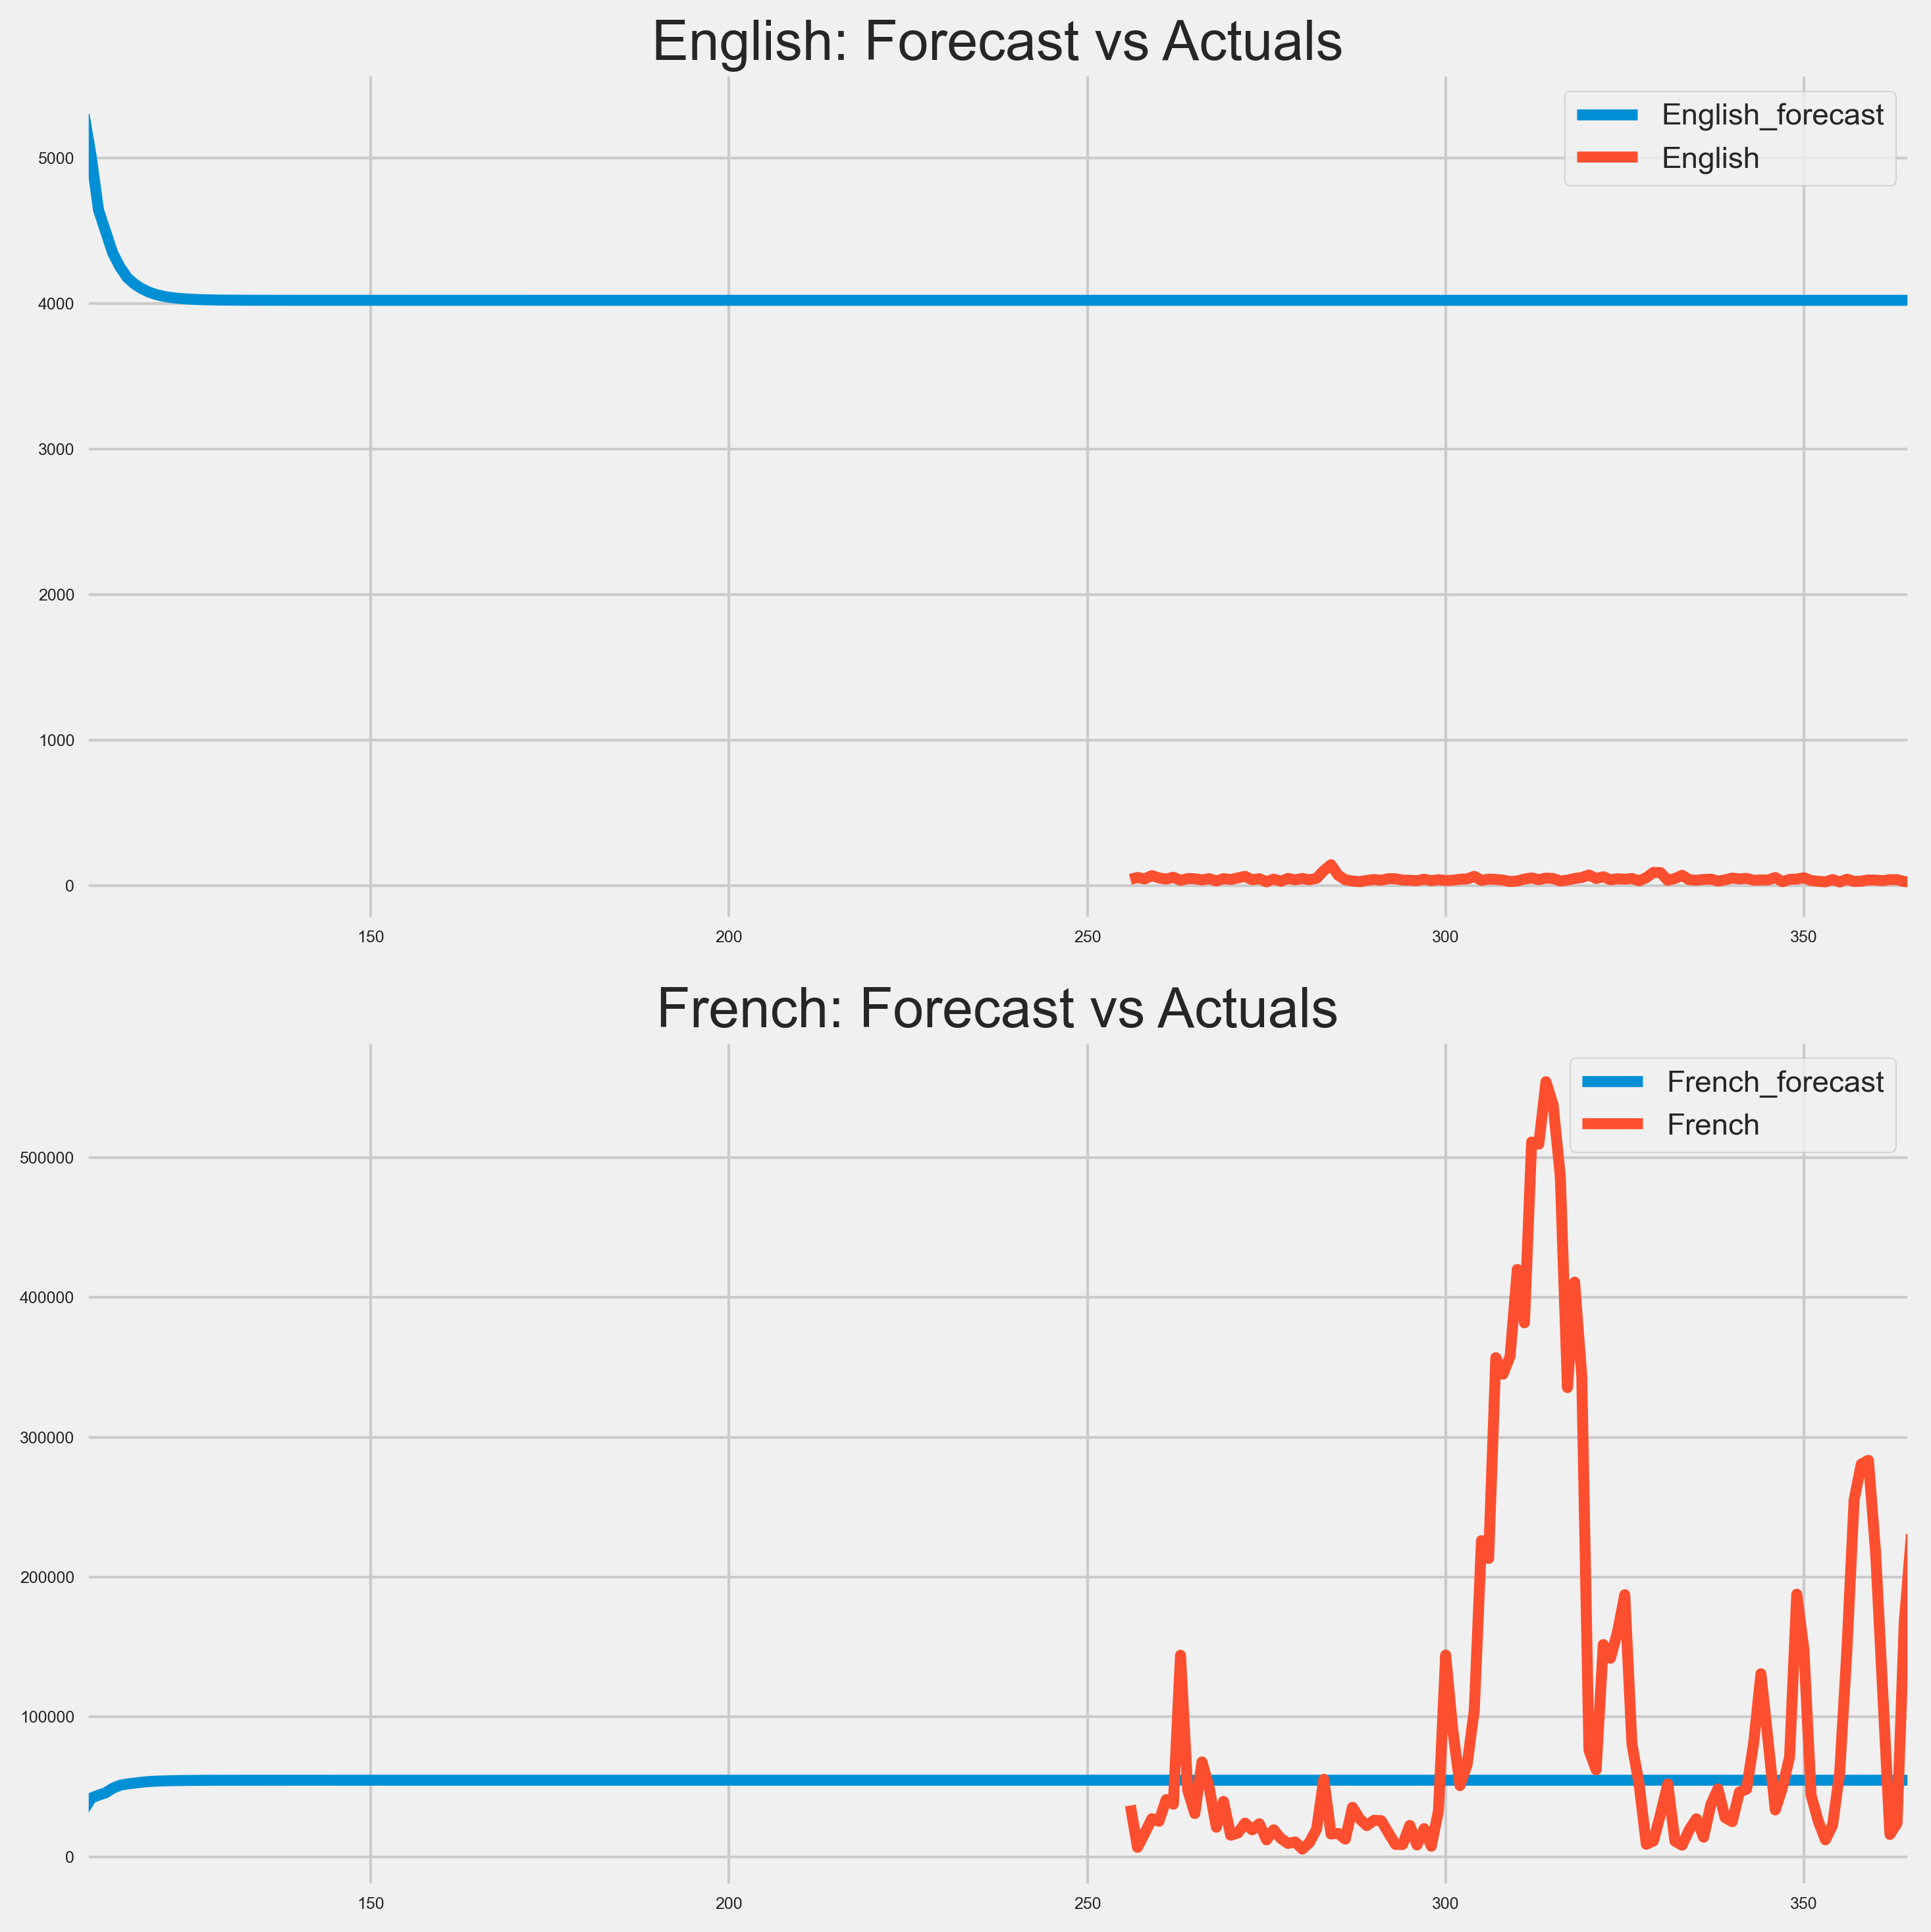

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(ts_df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Evaluate the Forecasts
To evaluate the forecasts, let’s compute a comprehensive set of metrics, namely, the MAPE, ME, MAE, MPE, RMSE, corr and minmax.

In [30]:
# Accuracy metrics
def timeseries_evaluation(ytest, ypreds, df_eval=None,show=False,
                          round_=2,index_name=None):
    from statsmodels.tsa.stattools import acf

    if not isinstance(df_eval, pd.DataFrame):
        df_eval = pd.DataFrame({'MAPE': [],
                                'ME': [],
                                'MAE': [],
                                'MPE': [],
                                'RMSE': [],
                                'CORR': [],
                                'MINMAX': [],
                                'ACF1': [],
                                })

    mape = np.mean(np.abs(ypreds - ytest)/np.abs(ytest))  # MAPE
    me = np.mean(ypreds - ytest)             # ME
    mae = np.mean(np.abs(ypreds - ytest))    # MAE
    mpe = np.mean((ypreds - ytest)/ytest)   # MPE
    rmse = np.mean((ypreds - ytest)**2)**.5  # RMSE
    corr = np.corrcoef(ypreds, ytest)[0, 1]   # corr
    mins = np.amin(np.hstack([ypreds[:, None],
                              ytest[:, None]]), axis=1)
    maxs = np.amax(np.hstack([ypreds[:, None],
                              ytest[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    acf1 = acf(ypreds-ytest, fft=False)[1]    # ACF1

    row = [mape, me, mae, mpe, rmse, corr, minmax, acf1]

    if index_name:
        df_eval.loc[index_name] =  row
        
    else:
        df_eval.loc[len(df_eval)] = row
    
    df_eval = df_eval.round(round_)
    
    if show:
        display(df_eval)
    return df_eval

col = 'English'
res = df_results[col+'_forecast'].to_numpy()[:len(df_test)]
tst = df_test[col].to_numpy()
timeseries_evaluation(tst, res)

/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,


,MAPE,ME,MAE,MPE,RMSE,CORR,MINMAX,ACF1
0,101.89,4019.65,4019.65,101.89,4023.29,0.08,0.99,0.71


In [31]:
for i,col in enumerate(df_test.columns):
    tst = df_test[col].to_numpy()
    res = df_results[col+'_forecast'].to_numpy()[:len(df_test)]

    df_eval = timeseries_evaluation(tst, res, df_eval=None,index_name=col) if i == 0 \
              else timeseries_evaluation(res, tst, df_eval=df_eval,index_name=col)
    
    
df_eval

/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,


,MAPE,ME,MAE,MPE,RMSE,CORR,MINMAX,ACF1
English,101.89,4019.65,4019.65,101.89,4023.29,0.08,0.99,0.71
French,1.58,51595.09,86356.80,0.94,145633.11,0.13,0.57,0.91
